# IMAGE STITCHING

In [76]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import lsmr
import random

DATA_PATH = "./data/data_image_stitching/"

## 1. Determine correspondences between images

### 1.1. Detecting feature points and feature descriptor

In [77]:
def get_feature_points_and_desciptors(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create()
    kp, des = sift.detectAndCompute(gray, None)
    return gray, kp, des

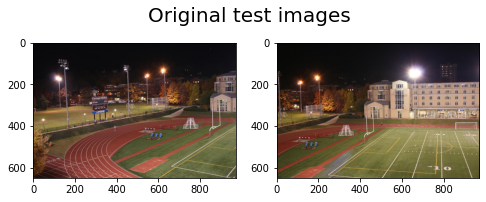

In [78]:
# Test images
path_img_1 = DATA_PATH + 'im89.jpg'
path_img_2 = DATA_PATH + 'im90.jpg'

# Read the images
img_1 = cv2.imread(path_img_1)
img_2 = cv2.imread(path_img_2)

fig, axes = plt.subplots(1,2, figsize=(8,3))
fig.suptitle("Original test images", fontsize=20)
axes[0].imshow(cv2.cvtColor(img_1, cv2.COLOR_BGR2RGB))
axes[1].imshow(cv2.cvtColor(img_2, cv2.COLOR_BGR2RGB))

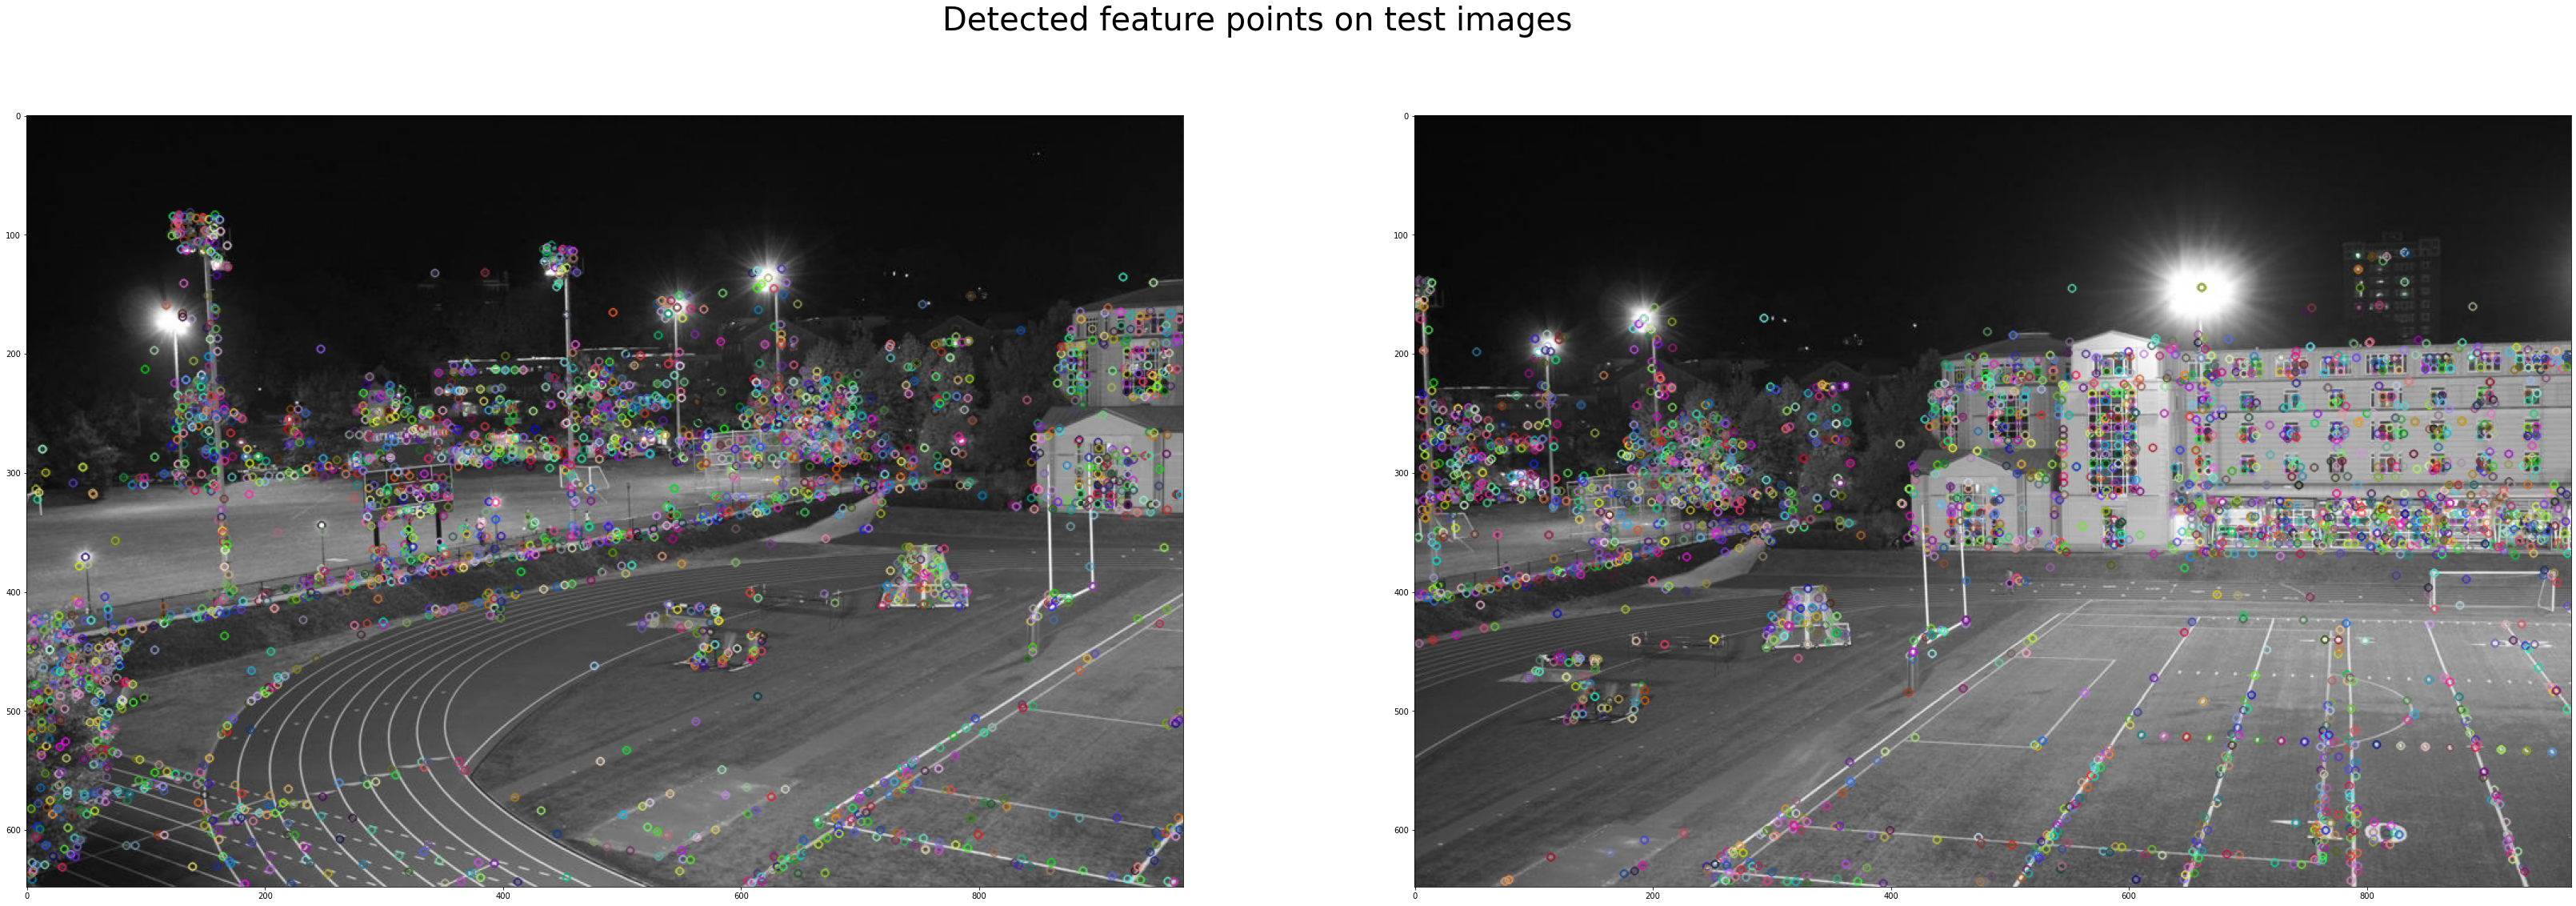

In [79]:
# Get feature points and Descriptors on test images
gimg_1, kp_1, desc_1 = get_feature_points_and_desciptors(img_1)
gimg_2, kp_2, desc_2 = get_feature_points_and_desciptors(img_2)

fimg_1 = cv2.drawKeypoints(gimg_1,kp_1,gimg_1)
fimg_2 = cv2.drawKeypoints(gimg_2,kp_2,gimg_2)

fig, axes = plt.subplots(1,2, figsize=(57,18))
fig.suptitle("Detected feature points on test images", fontsize=40)
axes[0].imshow(cv2.cvtColor(fimg_1, cv2.COLOR_BGR2RGB))
axes[1].imshow(cv2.cvtColor(fimg_2, cv2.COLOR_BGR2RGB))

### 1.2. Feature Matching

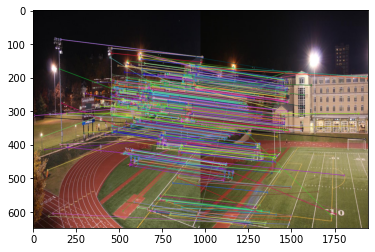

In [80]:
from scipy.spatial.distance import cdist

def match_feature_points(fd_1, fd_2, threshold):
    # Calculate euclidiean distance betweek feature descriptors
    distance_between_points = cdist(fd_1, fd_2, 'euclidean')

    # Sort the distances and keep the indices
    sorted_distance = np.sort(distance_between_points, axis=1)
    indices = np.argsort(distance_between_points, axis=1)

    # Calculate Nearest Neighbor Distance Ratio
    nearest_neighbor = sorted_distance[:, 0]
    sec_nearest_neighbor = sorted_distance[:, 1]
    nndr = np.divide(nearest_neighbor, sec_nearest_neighbor)

    # Get the features that NNDR is less the threshold
    good_points = np.where(nndr < threshold)

    # Keep valid feature indices
    good_points_distance = sorted_distance[good_points, 0]
    good_points_indices = indices[good_points,0]
    return np.column_stack((good_points[0], good_points_indices[0], good_points_distance[0]))

def convert_to_dmatch(elem):
    return cv2.DMatch(int(elem[0]), int(elem[1]), 0,elem[2])

def prepare_matches_for_drawing(matched_features):
    matched_features_in_dmatch = []
    for elem in matched_features:
        matched_features_in_dmatch.append(convert_to_dmatch(elem))
    return matched_features_in_dmatch

matched_features = match_feature_points(desc_1, desc_2, 0.8)
matched_features_in_dmatch = prepare_matches_for_drawing(matched_features)
matched_features_img = cv2.drawMatches(img_1, kp_1, img_2, kp_2, matched_features_in_dmatch, img_1,flags=2)
plt.imshow(cv2.cvtColor(matched_features_img, cv2.COLOR_BGR2RGB), aspect='auto')

## 2. Fitting a Homography

In [81]:
def convert_matches_for_ransac(kp1, kp2, dmatches):
    matches = []
    p1_all = []
    p2_all = []
    for dmatch in dmatches:
        p1 = np.array(kp1[dmatch.queryIdx].pt, dtype=np.int32)
        p2 = np.array(kp2[dmatch.trainIdx].pt, dtype=np.int32)
        matches.append([p1, p2])
        p1_all.append(p1)
        p2_all.append(p2)
    return matches, np.array(p1_all), np.array(p2_all)

def project(x, y, homography):
    # Create an homogenous coordinate
    hc_point = np.array((x, y, 1))

    # Matrix multiplication between the point and the homography
    hc_projected = np.matmul(homography, hc_point)

    # Get rid of homogenous coordinate
    projected = np.divide(hc_projected, hc_projected[2])

    return projected[0:2]

def compute_the_inliers(homography, matches, inlier_threshold):
    # Keep the indices of inliers
    index_of_inliers = []
    index = 0
    # Iterate over matches and keep the inliers
    for match in matches:
        p1 = match[0]
        p2 = match[1]

        # Calculate the projection of p1 with respect to homography
        projected_p1 = project(p1[0], p1[1], homography)
        pr_p1_arr = np.array((projected_p1[0], projected_p1[1]))
        p2_arr = np.array((p2[0], p2[1]))
        distance_between_projected_p1_and_p2 = np.linalg.norm(pr_p1_arr - p2_arr)
        #print(pr_p1_arr, p2_arr, distance_between_projected_p1_and_p2)
        if distance_between_projected_p1_and_p2 < inlier_threshold:
            index_of_inliers.append(index)
        index += 1

    return index_of_inliers

def create_matrix_for_points(random_matches, num_of_selected_samples):
    A = []
    B = np.zeros((num_of_selected_samples*2+1,1))
    B[num_of_selected_samples*2] = 1

    left_matches = len(random_matches)
    for random_match in random_matches:
        left_matches -= 1
        p1 = random_match[0]
        p2 = random_match[1]

        first_row = np.array([-p1[0], -p1[1], -1, 0, 0, 0, p1[0]*p2[0], p1[1]*p2[0], p2[0]])
        sec_row = np.array([0, 0, 0, -p1[0], -p1[1], -1, p1[0]*p2[1], p1[1]*p2[1], p2[1]])

        rows = np.vstack((first_row, sec_row))

        if len(A) == 0:
            A = rows
        else:
            A = np.vstack((A, rows))
    
    A = np.vstack((A, np.array([0, 0, 0, 0, 0, 0, 0, 0, 1])))
    
    return A, B


def solve_the_liner_system(A, B):
    u, s, vh  = np.linalg.svd(A)
    sol = np.divide(vh[-1], vh[-1][-1])
    return sol
    
def ransac(matches, iterations, inlier_threshold):
    best_homography = []
    highest_inlier = 0

    for i in range(0, iterations):
        random_matches = random.sample(matches, 4)

        A, B = create_matrix_for_points(random_matches, 4)
        solution = solve_the_liner_system(A, B)
        candidate_homography = solution.reshape((3, 3))
        normalized_homography = normalize_homography(candidate_homography)
        inliers = compute_the_inliers(normalized_homography, matches, inlier_threshold)
        if len(inliers) > highest_inlier:
            highest_inlier = len(inliers)
            best_homography = candidate_homography
    
    # Iterations are over, now use all points for the best homography
    inliers = compute_the_inliers(best_homography, matches, inlier_threshold)
    tmp_m = np.array(matches)
    A, B = create_matrix_for_points(tmp_m[inliers], len(inliers))
    solution = solve_the_liner_system(A, B)
    final_homography = solution.reshape((3, 3))
    norm_final_homography = normalize_homography(final_homography)
    return norm_final_homography

def normalize_homography(homography):
    return np.divide(homography, homography[-1, -1])
    #return homography

def convert_matches_for_visualization(matches, inliers):
    t = np.array(matches)
    return t[inliers]


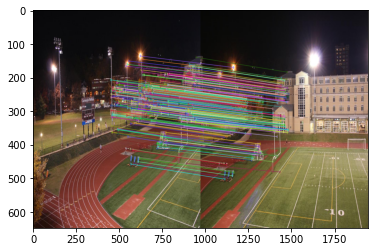

In [82]:
matches_for_ransac, p1_all, p2_all = convert_matches_for_ransac(kp_1, kp_2, matched_features_in_dmatch)

# Homography calculated by cv2
lib_h, status = cv2.findHomography(p1_all, p2_all)

# Homography calculated by us
fh = ransac(matches_for_ransac, 250, 0.8)

inliers = compute_the_inliers(fh, matches_for_ransac, 0.8)
inl = convert_matches_for_visualization(matched_features_in_dmatch, inliers)
inlier_img = cv2.drawMatches(img_1, kp_1, img_2, kp_2, inl, img_2, flags=2)
plt.imshow(cv2.cvtColor(inlier_img, cv2.COLOR_BGR2RGB), aspect='auto')

## 3. Image Stitching

In [83]:
# Following code is retrieved from https://github.com/OlehOnyshchak/ImageTransformations/blob/master/PerspectiveTransformation.ipynb
def to_mtx(img):
    H,V,C = img.shape
    mtr = np.zeros((V,H,C), dtype='int')
    for i in range(img.shape[0]):
        mtr[:,i] = img[i]
    
    return mtr

def to_img(mtr):
    V,H,C = mtr.shape
    img = np.zeros((H,V,C), dtype='int')
    for i in range(mtr.shape[0]):
        img[:,i] = mtr[i]
        
    return img

def warpPerspective(img, M, dsize):
    mtr = to_mtx(img)
    R,C = dsize
    dst = np.zeros((R,C,mtr.shape[2]))
    for i in range(mtr.shape[0]):
        for j in range(mtr.shape[1]):
            res = np.dot(M, [i,j,1])
            i2,j2,_ = (res / res[2] + 0.5).astype(int)
            if i2 >= 0 and i2 < R:
                if j2 >= 0 and j2 < C:
                    dst[i2,j2] = mtr[i,j]
    
    return to_img(dst)

(648, 1944, 3) (648, 1944, 3)


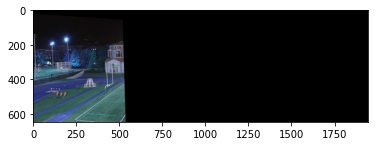

In [84]:
stitched_image = cv2.warpPerspective(img_1, fh, (img_1.shape[1] + img_2.shape[1], img_1.shape[0]))
warped_image = warpPerspective(img_1, fh, (img_1.shape[1] + img_2.shape[1], img_1.shape[0]))
print(warped_image.shape, stitched_image.shape)
plt.imshow(stitched_image)